In [1]:
# Load relevant packages

import pandas as pd
import numpy as np
import re
import csv
import operator
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction import _stop_words
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch

In [3]:
df = pd.read_csv("founta2018_formative2.csv")

In [4]:
df.sample(5, random_state = 123)

,tweet,label
42083,MK Dons Boss Robbie Neilson Hails Leicester Yo...,normal
72731,EXO's Sehun shares future plans for upcoming s...,normal
71150,What if I've recharged my number with 303 on 2...,normal
50169,Nice Move-in ready House with great views in w...,spam
36734,I wish I was an ear. They literally need to ea...,normal


In [5]:
def clean_text(text):

    #replace mentions and URLs with special token
       text = re.sub(r"@[A-Za-z0-9_-]+",'USR',text)
       text = re.sub(r"http\S+",'URL',text)
    
    # remove newline and tab characters
       text = text.replace('\n',' ')
       text = text.replace('\t',' ')
       text = text.replace('rt', ' ')

       text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # strip whitespace
       text = text.strip()
    
    # lowercase
       text = text.lower()
    
       return text

In [6]:
# Clean tweets
df["tweet"] = df.tweet.apply(lambda x: clean_text(x))

In [7]:
def drop_dupl(df):

    # save number of documents before dropping duplicates
    n_docs = df.shape[0]

    # drop duplicates
    df.drop_duplicates(subset = ['tweet'], inplace=True)

    print(f'{n_docs} posts, of which {n_docs - df.shape[0]} were dropped for being duplicates.')
    print(f'{df.shape[0]} posts remain. \n')
    
    return df

df = drop_dupl(df)

99996 posts, of which 12710 were dropped for being duplicates.
87286 posts remain. 



In [8]:
with open('FastText.pickle', 'rb') as handle:
    vecs = pickle.load(handle)

In [9]:
len(vecs)

140447

In [10]:
def lis(text):
  return text.split(' ')

In [11]:
df['cleaned'] = df.tweet.apply(lis)

In [12]:
# Define list of labels
labels = ['hateful', 'normal', 'abusive', 'spam']

# Define dictionary for label look-up
label2id = {'hateful': 0, 'normal': 1, 'abusive': 2, 'spam': 3}

# Define dictionary for reverse label look-up
id2label = {v: k for k, v in label2id.items()}

# Convert labels
df['label'] = df.label.apply(lambda x: label2id[x])

# FOR DEBUGGING: Reduce dataset size to make the task more computationally tractable
# data, _ = train_test_split(data, train_size=400, stratify=data['label'], random_state=0)

# Inspect dataframe
df

,tweet,label,cleaned
0,beats by dr. dre urbeats wired in-ear headphon...,3,"[beats, by, dr., dre, urbeats, wired, in-ear, ..."
1,rt usr: man it would fucking rule if we had a ...,2,"[rt, usr:, man, it, would, fucking, rule, if, ..."
2,"it is time to draw close to him father, i dr...",1,"[it, is, time, to, draw, close, to, him, , , f..."
3,if you notice me sta to act different or dist...,1,"[if, you, notice, me, sta, , to, act, differen..."
4,"forget unfollowers, i believe in growing. 7 ne...",1,"[forget, unfollowers,, i, believe, in, growing..."
...,...,...,...
99991,rt usr: my fucking queen url,2,"[rt, usr:, my, fucking, queen, url]"
99992,#osteporosis treated with #pemf - rebuild bone...,1,"[#osteporosis, treated, with, #pemf, -, rebuil..."
99993,usr why does my phone screen keeps flickring i...,1,"[usr, why, does, my, phone, screen, keeps, fli..."
99994,#bigdata vs. #reality ... but equally applies ...,1,"[#bigdata, vs., #reality, ..., but, equally, a..."


In [13]:
# Split data into training, development, and test sets
train, dev_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

In [14]:
# Define function to compute abstract embedding
def tweet2vec(a, vecs):
    return np.array([vecs[w] for w in a if w not in _stop_words.ENGLISH_STOP_WORDS and w in vecs]).mean(axis=0)

In [15]:
# Generate abstract embeddings
df['vec'] = df.cleaned.apply(lambda x: tweet2vec(x, vecs))

# Inspect data
df

,tweet,label,cleaned,vec
0,beats by dr. dre urbeats wired in-ear headphon...,3,"[beats, by, dr., dre, urbeats, wired, in-ear, ...","[0.1029635, 0.015414032, 0.039848752, -0.01176..."
1,rt usr: man it would fucking rule if we had a ...,2,"[rt, usr:, man, it, would, fucking, rule, if, ...","[0.120076925, 0.023571849, 0.04512241, -0.0145..."
2,"it is time to draw close to him father, i dr...",1,"[it, is, time, to, draw, close, to, him, , , f...","[0.05934707, 0.004570604, 0.024480723, -0.0053..."
3,if you notice me sta to act different or dist...,1,"[if, you, notice, me, sta, , to, act, differen...","[0.07843587, 0.0015229215, 0.033906847, -0.005..."
4,"forget unfollowers, i believe in growing. 7 ne...",1,"[forget, unfollowers,, i, believe, in, growing...","[0.10255028, 0.0099162245, 0.0412183, -0.00976..."
...,...,...,...,...
99991,rt usr: my fucking queen url,2,"[rt, usr:, my, fucking, queen, url]","[0.17864741, 0.052955687, 0.060966246, -0.0291..."
99992,#osteporosis treated with #pemf - rebuild bone...,1,"[#osteporosis, treated, with, #pemf, -, rebuil...","[0.09155674, 0.012652216, 0.035791688, -0.0099..."
99993,usr why does my phone screen keeps flickring i...,1,"[usr, why, does, my, phone, screen, keeps, fli...","[0.106647834, 0.013657742, 0.042137403, -0.011..."
99994,#bigdata vs. #reality ... but equally applies ...,1,"[#bigdata, vs., #reality, ..., but, equally, a...","[0.09347327, 0.005979382, 0.039065275, -0.0080..."


In [24]:
# Create dataset of vectors for t-SNE
tsne_vectors = np.array(list(df['vec']))

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40,early_exaggeration=7, n_iter=2000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

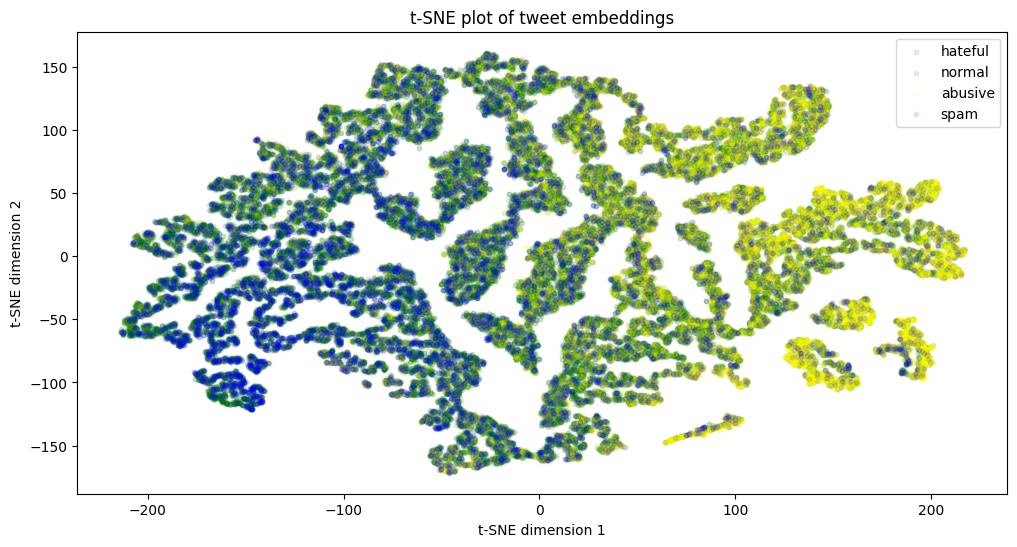

In [25]:
# Plot results
colors = {'hateful':'red', 'normal': 'green', 'abusive': 'yellow', 'spam':'blue'}
fig, ax = plt.subplots(1, figsize=(12, 6))

for l in labels:
    idx = [i for i, label in enumerate(df.label) if label == label2id[l]]
    ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=l, alpha=0.1, c=colors[l], s=10)

ax.set_title('t-SNE plot of tweet embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.legend()

plt.show()

In [ ]:
# Define dataset class
class LSTMDataset(Dataset):

    def __init__(self, data, w2id):
        
        # Encode abstracts
        self.tweets = list(data.cleaned.apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))
        
        # Store labels
        self.labels = list(data.label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

In [ ]:
# Define collate function
def lstm_collate(batch):
    
    # Store batch size
    batch_size = len(batch)

    # Separate abstracts and labels
    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()

    # Store length of longest abstract in batch
    max_len = max(len(t) for t in tweets)

    # Create padded abstract tensors
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)

    return tweets_pad, labels

In [ ]:
# Define LSTM classifier
class LSTMClassifier(nn.Module):
    
    def __init__(self, pretrained_emb, hidden_dim, output_dim):
        
        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
        self.lstm = nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, tweets):
            
        # Define flow of tensors through network
        emb = self.embedding(tweets)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        return self.linear(self.dropout(output[:, -1, :]))

In [ ]:
# Create dictionary for word look-up
word_counter = Counter([w for a in train.cleaned for w in a if w in vecs.keys()])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [ ]:
# Create datasets
train_dataset = LSTMDataset(train, w2id)
dev_dataset = LSTMDataset(dev, w2id)
test_dataset = LSTMDataset(test, w2id)

In [ ]:
# Create data loaders
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=lstm_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=lstm_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lstm_collate)

In [ ]:
# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor(np.array([vecs[id2w[i]] for i in range(2, len(id2w) + 2)])).float()
fasttext_emb = torch.cat((torch.zeros((1, 100)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)

In [ ]:
# Initialize model
model = LSTMClassifier(fasttext_emb, hidden_dim = 200, output_dim = 4)

In [ ]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

In [ ]:
# Train model
for e in range(1, 16):

    model.train()

    for i, b in enumerate(tqdm(train_loader)):
        
        # Perform forward pass
        optimizer.zero_grad()
        tweets, lbls = [t for t in b]
        output = model(tweets)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()

    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            tweets, lbls = [t for t in b]
            output = model(tweets)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())
            
    print('Development accuracy after {} epoch(s): {:.2f}'.format(e, accuracy_score(y_true, y_pred)))

100%|██████████| 699/699 [00:19<00:00, 36.26it/s]


Development accuracy after 1 epoch(s): 0.68


100%|██████████| 699/699 [00:18<00:00, 37.71it/s]


Development accuracy after 2 epoch(s): 0.70


100%|██████████| 699/699 [00:18<00:00, 36.84it/s]


Development accuracy after 3 epoch(s): 0.70


100%|██████████| 699/699 [00:18<00:00, 37.62it/s]


Development accuracy after 4 epoch(s): 0.70


100%|██████████| 699/699 [00:18<00:00, 37.50it/s]


Development accuracy after 5 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 37.28it/s]


Development accuracy after 6 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 37.65it/s]


Development accuracy after 7 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 37.35it/s]


Development accuracy after 8 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 38.03it/s]


Development accuracy after 9 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 37.06it/s]


Development accuracy after 10 epoch(s): 0.72


100%|██████████| 699/699 [00:18<00:00, 37.50it/s]


Development accuracy after 11 epoch(s): 0.71


100%|██████████| 699/699 [00:19<00:00, 36.31it/s]


Development accuracy after 12 epoch(s): 0.72


100%|██████████| 699/699 [00:18<00:00, 37.80it/s]


Development accuracy after 13 epoch(s): 0.71


100%|██████████| 699/699 [00:19<00:00, 36.74it/s]


Development accuracy after 14 epoch(s): 0.71


100%|██████████| 699/699 [00:18<00:00, 37.59it/s]


Development accuracy after 15 epoch(s): 0.72


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        tweets, lbls = [t for t in b]
        output = model(tweets)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print(classification_report(y_true,y_pred))
print(confusion_matrix(y_true,y_pred))

Test accuracy: 0.72
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       407
           1       0.73      0.93      0.81      5058
           2       0.74      0.71      0.72      2014
           3       0.62      0.15      0.24      1250

    accuracy                           0.72      8729
   macro avg       0.52      0.45      0.45      8729
weighted avg       0.68      0.72      0.67      8729

[[   0  235  172    0]
 [   0 4694  257  107]
 [   0  566 1440    8]
 [   0  972   90  188]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Split data into training, development, and test sets
train, dev_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

In [ ]:
train

,tweet,label,cleaned,vec
77802,so gis has now learnt how to trot and canter s...,1,"[so, gis, has, now, learnt, how, to, trot, and...","[0.09307726, 0.011459598, 0.037373397, -0.0102..."
19695,usr there's literally nothing else to be said ...,1,"[usr, there's, literally, nothing, else, to, b...","[0.11274307, 0.023323642, 0.04166504, -0.01504..."
49298,please rt? #moms #babies #parenting #dads cogn...,3,"[please, rt?, #moms, #babies, #parenting, #dad...","[0.09264697, 0.0076755006, 0.03841908, -0.0087..."
88118,i pampered myself with trefiel's the pamper cl...,3,"[i, pampered, myself, with, trefiel's, the, pa...","[0.080530435, 0.005117874, 0.033886973, -0.006..."
34842,rt usr: la fucking reina url,2,"[rt, usr:, la, fucking, reina, url]","[0.16218947, 0.04061074, 0.05832408, -0.024288..."
...,...,...,...,...
55785,f4499: japanese wooden lacquer ware small dini...,1,"[f4499:, japanese, wooden, lacquer, ware, smal...","[0.108665645, 0.018960224, 0.041736055, -0.013..."
80175,"#atxgig handyman type needed, housing availabl...",3,"[#atxgig, handyman, type, needed,, housing, av...","[0.076918125, 0.0069906013, 0.03158841, -0.007..."
64254,dexta daps releases debut album intro for fr...,1,"[dexta, daps, releases, debut, album, , intro,...","[0.07884348, 0.0067577246, 0.03268014, -0.0076..."
6042,usr no need to get triggered babe. sometimes y...,1,"[usr, no, need, to, get, triggered, babe., som...","[0.11494832, 0.019189008, 0.043759897, -0.0134..."


In [ ]:
X_train = train['vec']
y_train = train['label']

In [ ]:
import pandas as pd

# Convert labels to integers starting from 0
y_train = pd.Series(y_train).astype('category').cat.codes


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Convert the 'cleaned' column to a list of strings
documents = df['tweet']

# Create the bag-of-words embedding
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
y = df['label'].values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier on the train set
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier on the test set
accuracy = clf.score(X_test, y_test)
print("Classification accuracy: {:.2f}%".format(accuracy * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Classification accuracy: 76.97%
[[   9  372  396    9]
 [  27 8660  486 1083]
 [   9  461 3449   35]
 [   4  992  147 1319]]
              precision    recall  f1-score   support

           0       0.18      0.01      0.02       786
           1       0.83      0.84      0.84     10256
           2       0.77      0.87      0.82      3954
           3       0.54      0.54      0.54      2462

    accuracy                           0.77     17458
   macro avg       0.58      0.57      0.55     17458
weighted avg       0.74      0.77      0.75     17458



In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
import numpy as np

In [ ]:
X_train = X_train.todense() 

In [ ]:
X_test = X_test.todense() 

In [ ]:
X_train = np.asarray(X_train)

In [ ]:
X_test = np.asarray(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
p.fit(X_train,y_train) 

Pipeline(steps=[('Normalizing', MinMaxScaler()),
                ('MultinomialNB', MultinomialNB())])

In [ ]:
y_pred_mnb = p.predict(X_test)

# Evaluate the classifier on the test set
print(confusion_matrix(y_test,y_pred_mnb))
print(classification_report(y_test,y_pred_mnb))

[[   4  460  317    5]
 [  18 9003  525  710]
 [   7 1409 2508   30]
 [   3 1310  162  987]]
              precision    recall  f1-score   support

           0       0.12      0.01      0.01       786
           1       0.74      0.88      0.80     10256
           2       0.71      0.63      0.67      3954
           3       0.57      0.40      0.47      2462

    accuracy                           0.72     17458
   macro avg       0.54      0.48      0.49     17458
weighted avg       0.68      0.72      0.69     17458



In [47]:
# Load relevant packages

import pandas as pd
import numpy as np
import re
import csv
import operator
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

In [89]:
df = pd.read_csv("founta2018_formative2.csv")

In [90]:
df.sample(5, random_state = 123)

,tweet,label
42083,MK Dons Boss Robbie Neilson Hails Leicester Yo...,normal
72731,EXO's Sehun shares future plans for upcoming s...,normal
71150,What if I've recharged my number with 303 on 2...,normal
50169,Nice Move-in ready House with great views in w...,spam
36734,I wish I was an ear. They literally need to ea...,normal


In [91]:
def clean_text(text):

    #replace mentions and URLs with special token
       text = re.sub(r"@[A-Za-z0-9_-]+",'USR',text)
       text = re.sub(r"http\S+",'URL',text)
    
    # remove newline and tab characters
       text = text.replace('\n',' ')
       text = text.replace('\t',' ')
       text = text.replace('rt', ' ')

       text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # strip whitespace
       text = text.strip()
    
    # lowercase
       text = text.lower()
    
       return text

In [92]:
# Clean tweets
df["tweet"] = df.tweet.apply(lambda x: clean_text(x))

In [93]:
def drop_dupl(df):

    # save number of documents before dropping duplicates
    n_docs = df.shape[0]

    # drop duplicates
    df.drop_duplicates(subset = ['tweet'], inplace=True)

    print(f'{n_docs} posts, of which {n_docs - df.shape[0]} were dropped for being duplicates.')
    print(f'{df.shape[0]} posts remain. \n')
    
    return df

df = drop_dupl(df)

99996 posts, of which 12710 were dropped for being duplicates.
87286 posts remain. 



In [ ]:
with open('FastTextDictionary.pickle', 'rb') as handle:
    FastText = pickle.load(handle)

In [94]:
def lis(text):
  return text.split(' ')

In [95]:
df['cleaned'] = df.tweet.apply(lis)

In [66]:
df.label.replace({"hateful":"hateful","abusive": "non-hateful", "normal": "non-hateful", "spam": "non-hateful"}, inplace = True)

In [67]:
n_toxic = df[df.label=="non-hateful"].shape[0]
prop_toxic = df[df.label=="hateful"].shape[0]/df.shape[0]

print(f"{df.shape[0]} entries in the dataset")
print("{} total entries labelled as non-hateful; {:.2%} of total entries labelled as hateful\n".format(n_toxic, prop_toxic)) 

87286 entries in the dataset
83219 total entries labelled as non-hateful; 4.66% of total entries labelled as hateful



In [68]:
df2 = df[df['label']=="hateful"]
df3 = pd.concat([df,df2])

In [69]:
df= pd.concat([df3,df2])

In [70]:
df4 = df[df['label'] == "non-hateful"].sample(30000)
df4 = df4.reset_index()

In [71]:
drop_list = [i for i in df4['index']]

In [72]:
df = df.drop(drop_list, axis = 0)

In [73]:
len(df)

65420

In [74]:
n_toxic = df[df.label=="non-hateful"].shape[0]
prop_toxic = df[df.label=="hateful"].shape[0]/df.shape[0]

print(f"{df.shape[0]} entries in the dataset")
print("{} total entries labelled as toxic; {:.2%} of total entries labelled as toxic\n".format(n_toxic, prop_toxic)) 

65420 entries in the dataset
53219 total entries labelled as toxic; 18.65% of total entries labelled as toxic



In [75]:
df.head(5)

,tweet,label,cleaned
1,rt usr: man it would fucking rule if we had a ...,non-hateful,"[rt, usr:, man, it, would, fucking, rule, if, ..."
2,"it is time to draw close to him father, i dr...",non-hateful,"[it, is, time, to, draw, close, to, him, , , f..."
3,if you notice me sta to act different or dist...,non-hateful,"[if, you, notice, me, sta, , to, act, differen..."
4,"forget unfollowers, i believe in growing. 7 ne...",non-hateful,"[forget, unfollowers,, i, believe, in, growing..."
5,rt usr: hate being sexually frustrated like i ...,non-hateful,"[rt, usr:, hate, being, sexually, frustrated, ..."


In [96]:
# Split data into training, development, and test sets
train, dev_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

In [58]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import pickle
import numpy as np
import pandas as pd
import torch
import warnings

from collections import defaultdict, Counter
from string import punctuation
from matplotlib import pyplot as plt
from nltk.util import bigrams
from tqdm import tqdm

from sklearn.feature_extraction import _stop_words
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, BertTokenizer

warnings.filterwarnings("ignore", category=FutureWarning)

In [97]:
# Define dataset class
class BERTDataset(Dataset):

    def __init__(self, data):
        
        # Initialize tokenizer
        self.tok = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Truncate and encode abstracts
        self.tweets = (data.cleaned.apply(self.tok.encode, max_length=50, truncation=True))
        
        # Store labels
        self.labels = list(data.label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

In [98]:
def bert_collate(batch):
    # Store batch size
    batch_size = len(batch)
    
    # Separate tweets and labels
    tweets = [t for t, l in batch]
    labels = [l for t, l in batch]
    
    # Check that all labels are valid
    valid_labels = {"hateful", "normal", "abusive", "spam"}
    if not set(labels).issubset(valid_labels):
        raise ValueError("Invalid label found in batch: {}".format(labels))
    
    # Convert labels to integers
    label2id = {"hateful": 0, "normal": 1, "abusive" : 2, "spam": 3}
    label_ids = torch.tensor([label2id[l] for l in labels]).long()
    
    # Store length of longest tweet in batch
    max_len = max(len(t) for t in tweets)
    
    # Create padded tweet and attention mask tensors
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)
        masks_pad[i, :len(t)] = 1
    
    return tweets_pad, masks_pad, label_ids

In [99]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassifier class

class BertClassifier_RELU(nn.Module):
    
    def __init__(self, freeze_bert=False):
        super(BertClassifier,self).__init__()
        
        # Specify hidden size of Bert, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50 , 4
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.classifier = nn.Sequential(
                            nn.Linear(D_in, H),
                            nn.ReLU(),
                            nn.Linear(H, D_out))
        
        # Freeze the Bert Model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self,input_ids,attention_mask, output_attentions=True):

        outputs = self.bert(input_ids=input_ids,
                           attention_mask = attention_mask, output_attentions=True)
        
        overall = outputs

        attentions = outputs.attentions
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:,0,:]
        
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits, overall, attentions

In [119]:
# Define BERT classifier
class BERTClassifier(nn.Module):

    def __init__(self):
        
        # Define network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 4)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, tweets, masks, output_attentions=True):
        
        # Define flow of tensors through network
        outputs = self.bert(tweets, attention_mask=masks, output_attentions = True)
        attentions = outputs.attentions
        output_bert = self.bert(tweets, attention_mask=masks)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert)), outputs, attentions

In [100]:
train = train.reset_index()
dev = dev.reset_index()
test = test.reset_index()

In [110]:
# Create datasets
train_dataset = BERTDataset(train)
dev_dataset = BERTDataset(dev)
test_dataset = BERTDataset(test)

In [111]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

In [120]:
# Initialize model
model = BERTClassifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
!pip install sadice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from sadice import SelfAdjDiceLoss

criterion = SelfAdjDiceLoss()

In [30]:
import torch.nn as nn

class F1Loss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        tp = (y_pred * y_true).sum(dim=0)
        fp = (y_pred * (1 - y_true)).sum(dim=0)
        fn = ((1 - y_pred) * y_true).sum(dim=0)

        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        f1 = 2 * (precision * recall) / (precision + recall + self.eps)

        return 1 - f1.mean()

In [84]:
import torch.nn as nn

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights

    def forward(self, input, target):
        log_probs = nn.functional.log_softmax(input, dim=1)
        loss = nn.functional.nll_loss(log_probs, target, weight=self.weights)
        return loss

In [121]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [105]:
print(len(dev_loader))

88


In [116]:
from sklearn.metrics import confusion_matrix, classification_report

In [122]:
# Train model
for e in range(4):

    model.train()

    for i, b in enumerate(tqdm(train_loader)):

        # Perform forward pass
        optimizer.zero_grad()
        tweets, masks, lbls = [t for t in b]
        output,overall,attn = model(tweets, masks, output_attentions= True)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()
  
    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            tweets, masks, lbls = [t for t in b]
            output,overall,attn = model(tweets, masks)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())

    print("Finished epoch", e+1)

    print('Accuracy after {} epoch(s): {:.2f}'.format(e+1, accuracy_score(y_true, y_pred)))
    print(confusion_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred))

100%|██████████| 699/699 [24:01<00:00,  2.06s/it]


Finished epoch 1
Accuracy after 1 epoch(s): 0.74
[[  58  263   79    7]
 [  20 4568   60  410]
 [ 108  530 1322   53]
 [   0  656   50  545]]
              precision    recall  f1-score   support

           0       0.31      0.14      0.20       407
           1       0.76      0.90      0.82      5058
           2       0.87      0.66      0.75      2013
           3       0.54      0.44      0.48      1251

    accuracy                           0.74      8729
   macro avg       0.62      0.53      0.56      8729
weighted avg       0.73      0.74      0.73      8729



100%|██████████| 699/699 [23:55<00:00,  2.05s/it]


Finished epoch 2
Accuracy after 2 epoch(s): 0.76
[[  24  155  222    6]
 [  19 4251  302  486]
 [  10  187 1790   26]
 [   0  601   80  570]]
              precision    recall  f1-score   support

           0       0.45      0.06      0.10       407
           1       0.82      0.84      0.83      5058
           2       0.75      0.89      0.81      2013
           3       0.52      0.46      0.49      1251

    accuracy                           0.76      8729
   macro avg       0.64      0.56      0.56      8729
weighted avg       0.74      0.76      0.74      8729



100%|██████████| 699/699 [24:00<00:00,  2.06s/it]


Finished epoch 3
Accuracy after 3 epoch(s): 0.77
[[   7  224  174    2]
 [   5 4797  161   95]
 [   5  330 1672    6]
 [   0  982   62  207]]
              precision    recall  f1-score   support

           0       0.41      0.02      0.03       407
           1       0.76      0.95      0.84      5058
           2       0.81      0.83      0.82      2013
           3       0.67      0.17      0.27      1251

    accuracy                           0.77      8729
   macro avg       0.66      0.49      0.49      8729
weighted avg       0.74      0.77      0.72      8729



100%|██████████| 699/699 [23:52<00:00,  2.05s/it]


Finished epoch 4
Accuracy after 4 epoch(s): 0.76
[[  21  246  138    2]
 [   8 4824   99  127]
 [  23  422 1556   12]
 [   0  941   56  254]]
              precision    recall  f1-score   support

           0       0.40      0.05      0.09       407
           1       0.75      0.95      0.84      5058
           2       0.84      0.77      0.81      2013
           3       0.64      0.20      0.31      1251

    accuracy                           0.76      8729
   macro avg       0.66      0.50      0.51      8729
weighted avg       0.74      0.76      0.72      8729



In [123]:
torch.save(model.state_dict(), 'bert_finding_attention_50len.pth')

In [124]:
from transformers import BertTokenizer

# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [125]:
def display_sentence_attention(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    tensor_tokens = torch.tensor([indexed_tokens])

    # Create attention masks
    attention_mask = [1] * len(tokens)

    # Convert inputs to PyTorch tensors
    tensor_mask = torch.tensor([attention_mask])

    # Predict label and get attention scores
    with torch.no_grad():
        #outputs, attn_scores = model(tensor_tokens, tensor_mask, return_dict=False, output_attentions=True)
        outputs, all, attn_scores = model(tensor_tokens, tensor_mask, output_attentions=True)
        pred_label = torch.argmax(outputs).item()

    # Decode attention scores and display highlighted sentence
    attn_scores = _decode_output({'attentions': attn_scores})
    display(HTML(f'<strong>Predicted Label:</strong> {pred_label}'))
    for layer in range(len(attn_scores['aa']['attn'])):
        for head in range(len(attn_scores['aa']['attn'][layer])):
            display(HTML(f'<strong>Layer {layer+1} Head {head+1}:</strong>'))
            disp_attn_tokens(tokens, attn_scores['aa']['attn'], layer, head)

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML
import html

In [232]:
import html

def display_attention(tokens, attn_matrix, layer=-1, head=0, direction='ba'):
    token_weights = attn_matrix[layer][head].detach().cpu().numpy()
    tokens = [t for t in tokens if t != tokenizer.pad_token]
    attention_weights = token_weights[direction == 'ba'][0]
    highlighted_text = []
    for i, (token, weight) in enumerate(zip(tokens, attention_weights)):
        if weight != 0:
            # Calculate the background color for the current token based on its attention weight
            color = f'rgba(255,0,0,{weight:.8f})'
            # If this isn't the first token in the sentence, calculate the color for the previous token as well
            if i > 0:
                prev_weight = attention_weights[i-1]
                if prev_weight != 0:
                    prev_color = f'rgba(255,0,0,{prev_weight:.8f})'
                else:
                    prev_color = 'white'
            else:
                prev_color = 'white'
            # Add the current token to the highlighted text string with a gradient background color
            highlighted_text.append(f'<span style="background: linear-gradient(to right, {prev_color}, {color})">{html.escape(str(token))}</span>')
        else:
            highlighted_text.append(str(token))
    highlighted_text = ' '.join(highlighted_text)
    display(HTML(highlighted_text))

In [178]:
def display_attention_2(tokens, attn_matrix, layer=-1, head=0, direction='ba'):
    token_weights = attn_matrix[layer][head].detach().cpu().numpy()
    attention_weights = token_weights[direction == 'ba'][0][:len(tokens)]
    tokens = [t for t in tokens if t != tokenizer.pad_token]
    highlighted_text = []
    for i, (token, weight) in enumerate(zip(tokens, attention_weights)):
        color = f'rgba(255,0,0,{weight:.2f})'
        highlighted_text.append(f'<span style="background-color: {color}">{html.escape(token)}</span>')
    highlighted_text = ' '.join(highlighted_text)
    display(HTML(highlighted_text))


In [250]:

input_text = "If you're a black person, kill yourself!!!! url"
tokens = tokenizer.encode_plus(input_text, max_length=128, truncation=True, padding='max_length', return_tensors='pt')

# Get BERT model predictions and attentions
predictions, outputs, attentions = model(tokens['input_ids'], tokens['attention_mask'])


# Reshape attention tensor
n_heads = attentions[11].shape[1]
attn_matrix = attentions[-1].reshape(n_heads, tokens['input_ids'].shape[1], tokens['input_ids'].shape[1])

decoded_tokens = tokenizer.decode(tokens['input_ids'][0])
decoded_tokens = decoded_tokens.split(' ')

display_attention(decoded_tokens, attn_matrix, layer= 1, head=11)


In [133]:
df['tweet'][df['label']=="hateful"].sample(1)

64557    the improve troupe changed the names of all th...
Name: tweet, dtype: object

In [136]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        tweets, masks, lbls = [t for t in b]
        output, overall, attn = model(tweets, masks)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true, y_pred))

Test accuracy: 0.77
[[  18  243  144    2]
 [   9 4815  108  126]
 [  20  407 1577   10]
 [   0  922   49  279]]
              precision    recall  f1-score   support

           0       0.38      0.04      0.08       407
           1       0.75      0.95      0.84      5058
           2       0.84      0.78      0.81      2014
           3       0.67      0.22      0.33      1250

    accuracy                           0.77      8729
   macro avg       0.66      0.50      0.52      8729
weighted avg       0.74      0.77      0.73      8729



In [138]:
schema = {0:"hateful",1:"normal", 2:"abusive", 3:"spam"}
test['pred'] = [schema[i] for i in y_pred]

In [197]:
check = test[test['label']=="hateful"]
check = check.reset_index()
check[check["pred"]=="hateful"].sample(5)

,level_0,index,tweet,label,cleaned,pred
184,4209,22183,usr usr too bad he's a xenophobic idiot with t...,hateful,"[usr, usr, too, bad, he's, a, xenophobic, idio...",hateful
249,5258,73986,rt usr: i'm embarrassed for those that voted f...,hateful,"[rt, usr:, i'm, embarrassed, for, those, that,...",hateful
312,6531,27101,professor: republicans criticize susan rice be...,hateful,"[professor:, republicans, criticize, susan, ri...",hateful
218,4769,78749,rt usr: you know niggas hate water smh url,hateful,"[rt, usr:, you, know, niggas, hate, water, smh...",hateful
93,2114,83496,"usr usr he is rubbish, a subhuman idiot ! him ...",hateful,"[usr, usr, he, is, rubbish,, a, subhuman, idio...",hateful


In [199]:
check['tweet'].iloc[184]

"usr usr too bad he's a xenophobic idiot with the reading level of a 3rd grader with racist parents"

In [236]:
train[train['label']=="hateful"].sample(5)

,index,tweet,label,cleaned
64845,43829,don't hate you because niggas can't appreciate...,hateful,"[don't, hate, you, because, niggas, can't, app..."
10558,72500,usr usr usr plenty of rats and rabbits are kil...,hateful,"[usr, usr, usr, plenty, of, rats, and, rabbits..."
8387,27095,rt usr: nigga u crazy url,hateful,"[rt, usr:, nigga, u, crazy, url]"
18479,79835,i question whether or not the filthy casuals w...,hateful,"[i, question, whether, or, not, the, filthy, c..."
36941,96195,anybody that does not obey the teachings of th...,hateful,"[anybody, that, does, not, obey, the, teaching..."


In [237]:
train['tweet'].iloc[36941]

'anybody that does not obey the teachings of the bible and jesus christ is a child of the devil a worker of iniquity url'